In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
import ast
import json
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from util import bfs

# Notebook to analyze the answers to rank assignment tasks

In [4]:
error_msgs = [
    "An error occurred. If this issue persists please contact us through our help center at help.openai.com.",
    "There was an error generating a response",
    "Hmm...something seems to have gone wrong. Maybe try me again in a little bit.",
    "The server had an error while processing your request",
    "Too many requests in 1 hour. Try again later.",
]
unreachable_msgs = [
    "infinity",
    "INF",
    "∞",
    "inf",
    "unreachable",
    # "-1",
]

## Helpers

In [5]:
def read_single_answer_block(answer: str) -> dict:
    # If the answer is comma separated on a single line
    # then split it into multiple lines
    if "," in answer:
        answer = answer.replace(",", "\n")

    # Each line is supposed to be a node-rank pair
    answer_lines = answer.split("\n")
    answer_ranks = defaultdict(list)
    for line in answer_lines:
        if line.strip() == "":
            continue
        if "-" in line:
            line = line.split("-")
        else:
            line = line.split(":")
        assert len(line) == 2, "Malformed answer line: {}".format(line)

        node = int(line[0].strip())
        rank = int(line[1].strip())

        answer_ranks[rank].append(node)

    return answer_ranks

def read_rank_answers(answer_files: list, answer_dir: str):
    # We can now read the answer files
    answers = {}
    answers_error = {}
    answers_malformed = {}
    # Some times the answer contains an unreachable node
    # This is always wrong
    answers_inf = {}

    for af in answer_files:
        with open(os.path.join(answer_dir, af), "r") as f:
            answer = f.read().strip()

        if any([em in answer for em in error_msgs]):
            answers_error[af] = answer
            continue

        if any([um in answer for um in unreachable_msgs]):
            answers_inf[af] = answer
            continue

        # Remove the final dot if present
        if answer[-1] == ".":
            answer = answer[:-1]

        try:
            answer_ranks = read_single_answer_block(answer)

        except Exception as e:
            answers_malformed[af] = answer
            continue

        answers[af] = answer_ranks

    print("Found {} malformed answers".format(len(answers_malformed)))
    print("Found {} unreachable answers".format(len(answers_inf)))
    print("Found {} error answers".format(len(answers_error)))
    print("Found {} valid answers".format(len(answers)))

    return answers, answers_error, answers_malformed, answers_inf


def compute_correct_pct(answers: dict, queries_gt):
    answers_standard_pct = {}
    for af in answers:
        answer_ranks = answers[af]
        gt_ranks = queries_gt[af]
        num_nodes = 0
        num_correct = 0.0
        for rank, nodes in answer_ranks.items():
            nodes_gt = gt_ranks.get(rank, [])
            for node in nodes:
                num_nodes += 1
                if node in nodes_gt:
                    num_correct += 1.0
        answers_standard_pct[af] = (num_correct / num_nodes) * 100.0

    return answers_standard_pct


def get_aggregate_stats(
    answers_pct: dict, answers_malformed: dict, answers_inf: dict, total_answers: int
):
    df = pd.DataFrame.from_dict(answers_pct, orient="index", columns=["Correct [%]"])

    # Let's also compute some aggregate stats
    aggr = {}
    pct_perfect = len(df[df["Correct [%]"] == 100.0])
    pct_high = len(df[(df["Correct [%]"] >= 50.0) & (df["Correct [%]"] < 100.0)])
    pct_low = len(df[df["Correct [%]"] < 50.0])
    pct_incorrect = len(answers_malformed) + len(answers_inf)

    aggr["Perfect answers"] = (pct_perfect / total_answers) * 100.0
    aggr["Valid answers\n(>= 0.5 correct)"] = (pct_high / total_answers) * 100.0
    aggr["Valid answers\n(< 0.5 correct)"] = (pct_low / total_answers) * 100.0
    aggr["Incorrectly reported\nunreachable nodes"] = (
        pct_incorrect / total_answers
    ) * 100.0
    
    aggr = pd.DataFrame.from_dict(aggr, orient="index", columns=["Value"])

    print(f"Found {pct_perfect} perfect answers")
    print(f"Found {pct_high} answers with >= 50% correct")
    print(f"Found {pct_low} answers with < 50% correct")
    print(f"Found {pct_incorrect} incorrect answers")

    return df, aggr


def visualize_results(df: pd.DataFrame, aggr: pd.DataFrame, color: str = "skyblue"):
    sns.set(rc={"figure.figsize": (8, 3)})

    sns.histplot(df, stat="count", bins=100, color=color)
    plt.xlabel("Ratio of nodes assigned to correct rank")
    plt.ylabel("Frequency")
    plt.show()

    sns.barplot(x=aggr.index, y="Value", data=aggr, color=color)
    plt.ylabel("Percentage")
    plt.show()


## Standard

We will start by looking at the responses to standard queries, with minimal promopt shaping.

In [6]:
def read_prompt_edge_list(query: str) -> list:
    rank_prompt_edge_list = (
        query.split("edge connections:")[1]
        .split("Perform a rank assignment")[0]
        .strip()
    )
    rank_prompt_edge_list = list(ast.literal_eval(rank_prompt_edge_list))
    return rank_prompt_edge_list

In [7]:
# Let's indentify all the query and answer files
query_dir_standard = "queries/rank_prompts"
query_files_standard = sorted(os.listdir(query_dir_standard))
print(f"Found {len(query_files_standard)} queries")

answer_dir_standard = "answers/rank_prompts"
answer_files_standard = sorted(os.listdir(answer_dir_standard))
print(f"Found {len(answer_files_standard)} answers")

for af in answer_files_standard:
    assert af in query_files_standard

Found 134 queries
Found 134 answers


In [8]:
# Let's start by reading in the queries
queries_standard = {}
for qf in query_files_standard:
    with open(os.path.join(query_dir_standard, qf), "r") as f:
        query = f.read()
    query_edges = read_prompt_edge_list(query)
    queries_standard[qf] = query_edges

# We can now compute the ground truth for each query
queries_standard_gt = {}
for qf in sorted(queries_standard):
    gt = bfs(queries_standard[qf], start_node=0)
    queries_standard_gt[qf] = gt

# And now read in the answers
(
    answers_standard,
    answers_standard_error,
    answers_standard_malformed,
    answers_standard_inf,
) = read_rank_answers(answer_files_standard, answer_dir_standard)

Found 0 malformed answers
Found 6 unreachable answers
Found 27 error answers
Found 101 valid answers


In [9]:
# We can now evaluate the correctness of the valid answers
# As evaluation metric, we will compute the percentage of nodes
# assigned to the correct rank
answers_standard_pct = compute_correct_pct(answers_standard, queries_standard_gt)
df_standard, aggr_standard = get_aggregate_stats(
    answers_standard_pct,
    answers_standard_malformed,
    answers_standard_inf,
    len(answer_files_standard) - len(answers_standard_error),
)

Found 3 perfect answers
Found 56 answers with >= 50% correct
Found 42 answers with < 50% correct
Found 6 incorrect answers


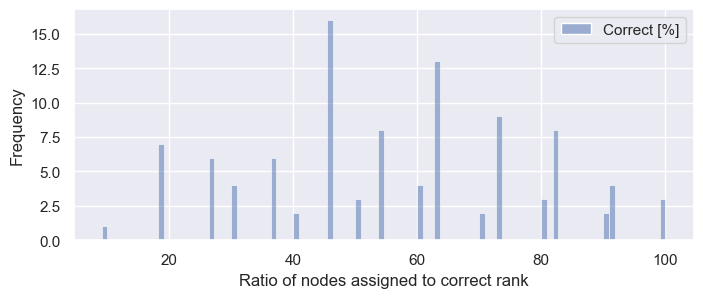

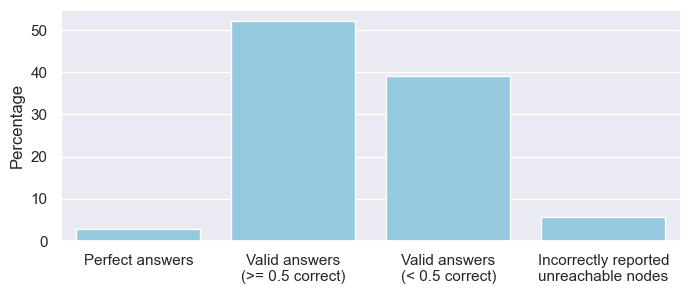

In [10]:
# We can now visualize the distribution of the correctness
visualize_results(df_standard, aggr_standard)

## In context learning

We can now look at the results obtained with in context learning

Found 100 answers
Found 0 malformed answers
Found 2 unreachable answers
Found 0 error answers
Found 98 valid answers
Found 2 perfect answers
Found 56 answers with >= 50% correct
Found 40 answers with < 50% correct
Found 2 incorrect answers


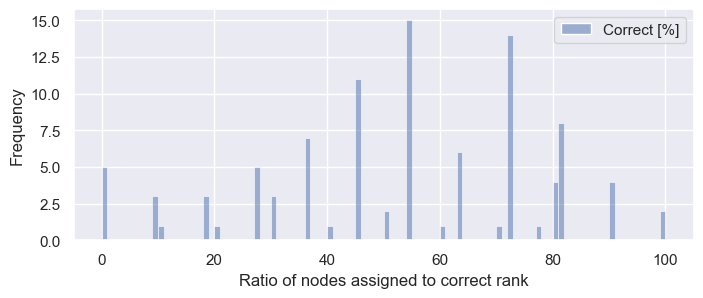

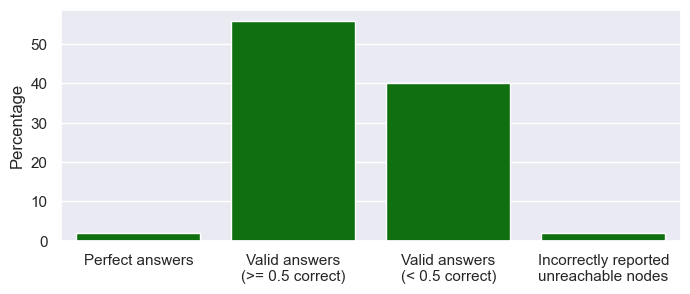

In [11]:
answer_dir_icl = "answers/rank_prompts_icl"
answer_files_icl = sorted(os.listdir(answer_dir_icl))
print(f"Found {len(answer_files_icl)} answers")

for af in answer_files_icl:
    assert af in query_files_standard

# We can now read the answer files
(
    answers_icl,
    answers_icl_error,
    answers_icl_malformed,
    answers_icl_inf,
) = read_rank_answers(answer_files_icl, answer_dir_icl)

# We can now evaluate the correctness of the valid answers
answers_icl_pct = compute_correct_pct(answers_icl, queries_standard_gt)

df_icl, aggr_icl = get_aggregate_stats(
    answers_icl_pct,
    answers_icl_malformed,
    answers_icl_inf,
    len(answer_files_icl) - len(answers_icl_error),
)

# Visualize the results
visualize_results(df_icl, aggr_icl, "green")


## Step by step reasoning

We can now look at the results obtained with step by step reasoning.

In [12]:
answer_dir_steps = "answers/rank_prompts_steps"
answer_files_steps = sorted(os.listdir(answer_dir_steps))

# Some files in Rome are duplicates 
duplicate_fnames = json.load(open("duplicated_fnames.json", "r"))
for dp, other_fname in duplicate_fnames.items():
    if dp in answer_files_steps:
        # Move the file to the other name
        shutil.move(
            os.path.join(answer_dir_steps, dp),
            os.path.join(answer_dir_steps, other_fname),
        )
        answer_files_steps.remove(dp)
        answer_files_steps.append(other_fname)

answer_files_steps = sorted(answer_files_steps)

for af in answer_files_steps:
    assert af in query_files_standard, f"{af} not in {query_files_standard}"

print(f"Found {len(answer_files_steps)} answers")

Found 50 answers


In [13]:
# This set of answers has a different format, so we need to read them in differently
answers_step = {}
answers_step_error = {}
answers_step_malformed = {}
# Some times the answer contains an unreachable node
# This is always wrong
answers_step_inf = {}

for af in answer_files_steps:
    with open(os.path.join(answer_dir_steps, af), "r") as f:
        answer = f.read().strip()

    if any([em in answer for em in error_msgs]):
        answers_step_error[af] = answer
        continue

    if "Copy code" not in answer:
        answers_step_error[af] = answer
        continue

    answer = answer.split("Copy code")[-1].strip()
    if any([um in answer for um in unreachable_msgs]):
        answers_step_inf[af] = answer
        continue

    try:
        # Each line of the expected answer should contain a ":" or a "-"
        # If it does not, the line could be additional explanation, and we can ignore it
        answer_lines = answer.splitlines()

        answer_lines = [al for al in answer_lines if ":" in al or "-" in al]
        # Some times the lines contain the name of the layer, like "Layer 1:"
        # which is a repetition. We can remove it
        answer_lines = [al for al in answer_lines if "Layer " not in al]

        # If no lines are left, the answer is malformed
        if len(answer_lines) == 0:
            answers_step_malformed[af] = answer
            continue

        # The answer should be a list of lines, each line containing a node and its rank
        answer_ranks = defaultdict(list)
        for line in answer_lines:
            if line.strip() == "":
                continue
            if "-" in line:
                line = line.split("-")
            else:
                line = line.split(":")
            assert len(line) == 2

            node = int(line[0].strip())
            rank = int(line[1].strip())

            answer_ranks[rank].append(node)

    except Exception as e:
        answers_step_malformed[af] = answer
        continue

    answers_step[af] = answer_ranks

print(f"Found {len(answers_step)} valid answers")
print(f"Found {len(answers_step_error)} error answers")
print(f"Found {len(answers_step_malformed)} malformed answers")
print(f"Found {len(answers_step_inf)} unreachable answers")


Found 41 valid answers
Found 0 error answers
Found 9 malformed answers
Found 0 unreachable answers


In [14]:
# Since the formatting can vary a lot, we will manually check the malformed answers
print("Malformed answers:", answers_step_malformed.keys())

additional_step = {}
additional_step["grafo1629.11.txt"] = """0: 0
1: 1
4: 1
7: 2
9: 2
8: 2
2: 2
5: 2
3: 2
6: 3
10: 3"""
additional_step["grafo1822.11.txt"] = """0: 0
1: 1
3: 1
2: 2
8: 2
4: 2
6: 2
5: 3
7: 3
9: 4
10: 5"""
additional_step["grafo1866.11.txt"] = """0: 0
1: 1
2: 3
3: 1
4: 2
5: 1
6: 2
7: 1
8: 2
9: 2
10: 4"""
additional_step["grafo1920.11.txt"] = """0: 0
1: 1
3: 1
2: 1
6: 2
8: 2
4: 2
9: 2
5: 3
7: 3
10: 4"""
additional_step["grafo273.11.txt"] = """0: 0
6: 1
1: 2
5: 1
9: 2
4: 2
8: 3
3: 3
7: 4
10: 4
2: 4"""
additional_step["grafo675.11.txt"] = """0: 0
1: 1
2: 1
3: 2
4: 3
5: 2
6: 2
7: 1
8: 3
9: 2
10: 2"""
additional_step["grafo849.11.txt"] = """0: 0
6: 1
7: 1
2: 1
1: 2
5: 2
10: 2
8: 2
9: 3
4: 4"""
additional_step["grafo949.10.txt"] = """0: 0
5: 1
1: 1
7: 1
6: 1
2: 2
8: 2
3: 2
9: 3"""

for af in additional_step:
    if af in answers_step_malformed:
        answers_step_malformed.pop(af)
    answer = read_single_answer_block(additional_step[af])
    answers_step[af] = answer

Malformed answers: dict_keys(['grafo1629.11.txt', 'grafo1822.11.txt', 'grafo1866.11.txt', 'grafo1920.11.txt', 'grafo2312.11.txt', 'grafo273.11.txt', 'grafo675.11.txt', 'grafo849.11.txt', 'grafo949.10.txt'])


Found 1 perfect answers
Found 31 answers with >= 50% correct
Found 17 answers with < 50% correct
Found 1 incorrect answers


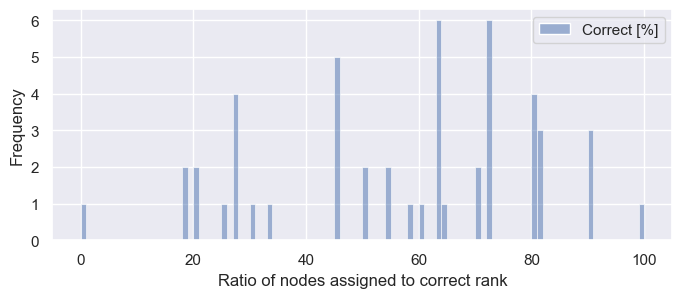

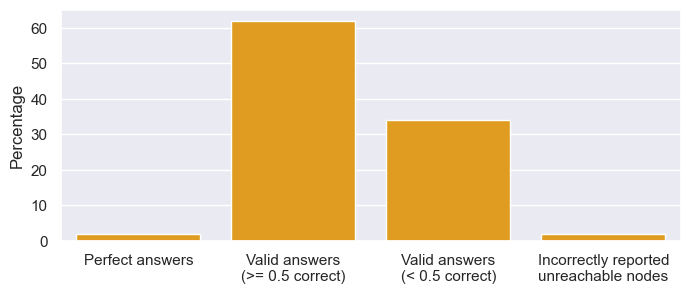

In [15]:
# We can now evaluate the correctness of the valid answers
answers_step_pct = compute_correct_pct(answers_step, queries_standard_gt)

df_step, aggr_step = get_aggregate_stats(
    answers_step_pct,
    answers_step_malformed,
    answers_step_inf,
    len(answer_files_steps) - len(answers_step_error),
)

# Visualize the results
visualize_results(df_step, aggr_step, "orange")


## Side by side graphs

In [16]:
df_standard_plt = df_standard
df_standard_plt["Type"] = "Standard"
df_step_plt = df_step
df_step_plt["Type"] = "Step"
df_icl_plt = df_icl
df_icl_plt["Type"] = "ICL"

df = pd.concat([df_standard_plt, df_step_plt, df_icl_plt])

aggr_standard_plt = aggr_standard
aggr_standard_plt["Type"] = "Standard"
aggr_step_plt = aggr_step
aggr_step_plt["Type"] = "Step"
aggr_icl_plt = aggr_icl
aggr_icl_plt["Type"] = "ICL"

aggr = pd.concat([aggr_standard_plt, aggr_step_plt, aggr_icl_plt])

In [17]:
aggr

,Value,Type
Perfect answers,2.803738,Standard
Valid answers\n(>= 0.5 correct),52.336449,Standard
Valid answers\n(< 0.5 correct),39.252336,Standard
Incorrectly reported\nunreachable nodes,5.607477,Standard
Perfect answers,2.000000,Step
Valid answers\n(>= 0.5 correct),62.000000,Step
Valid answers\n(< 0.5 correct),34.000000,Step
Incorrectly reported\nunreachable nodes,2.000000,Step
Perfect answers,2.000000,ICL
Valid answers\n(>= 0.5 correct),56.000000,ICL


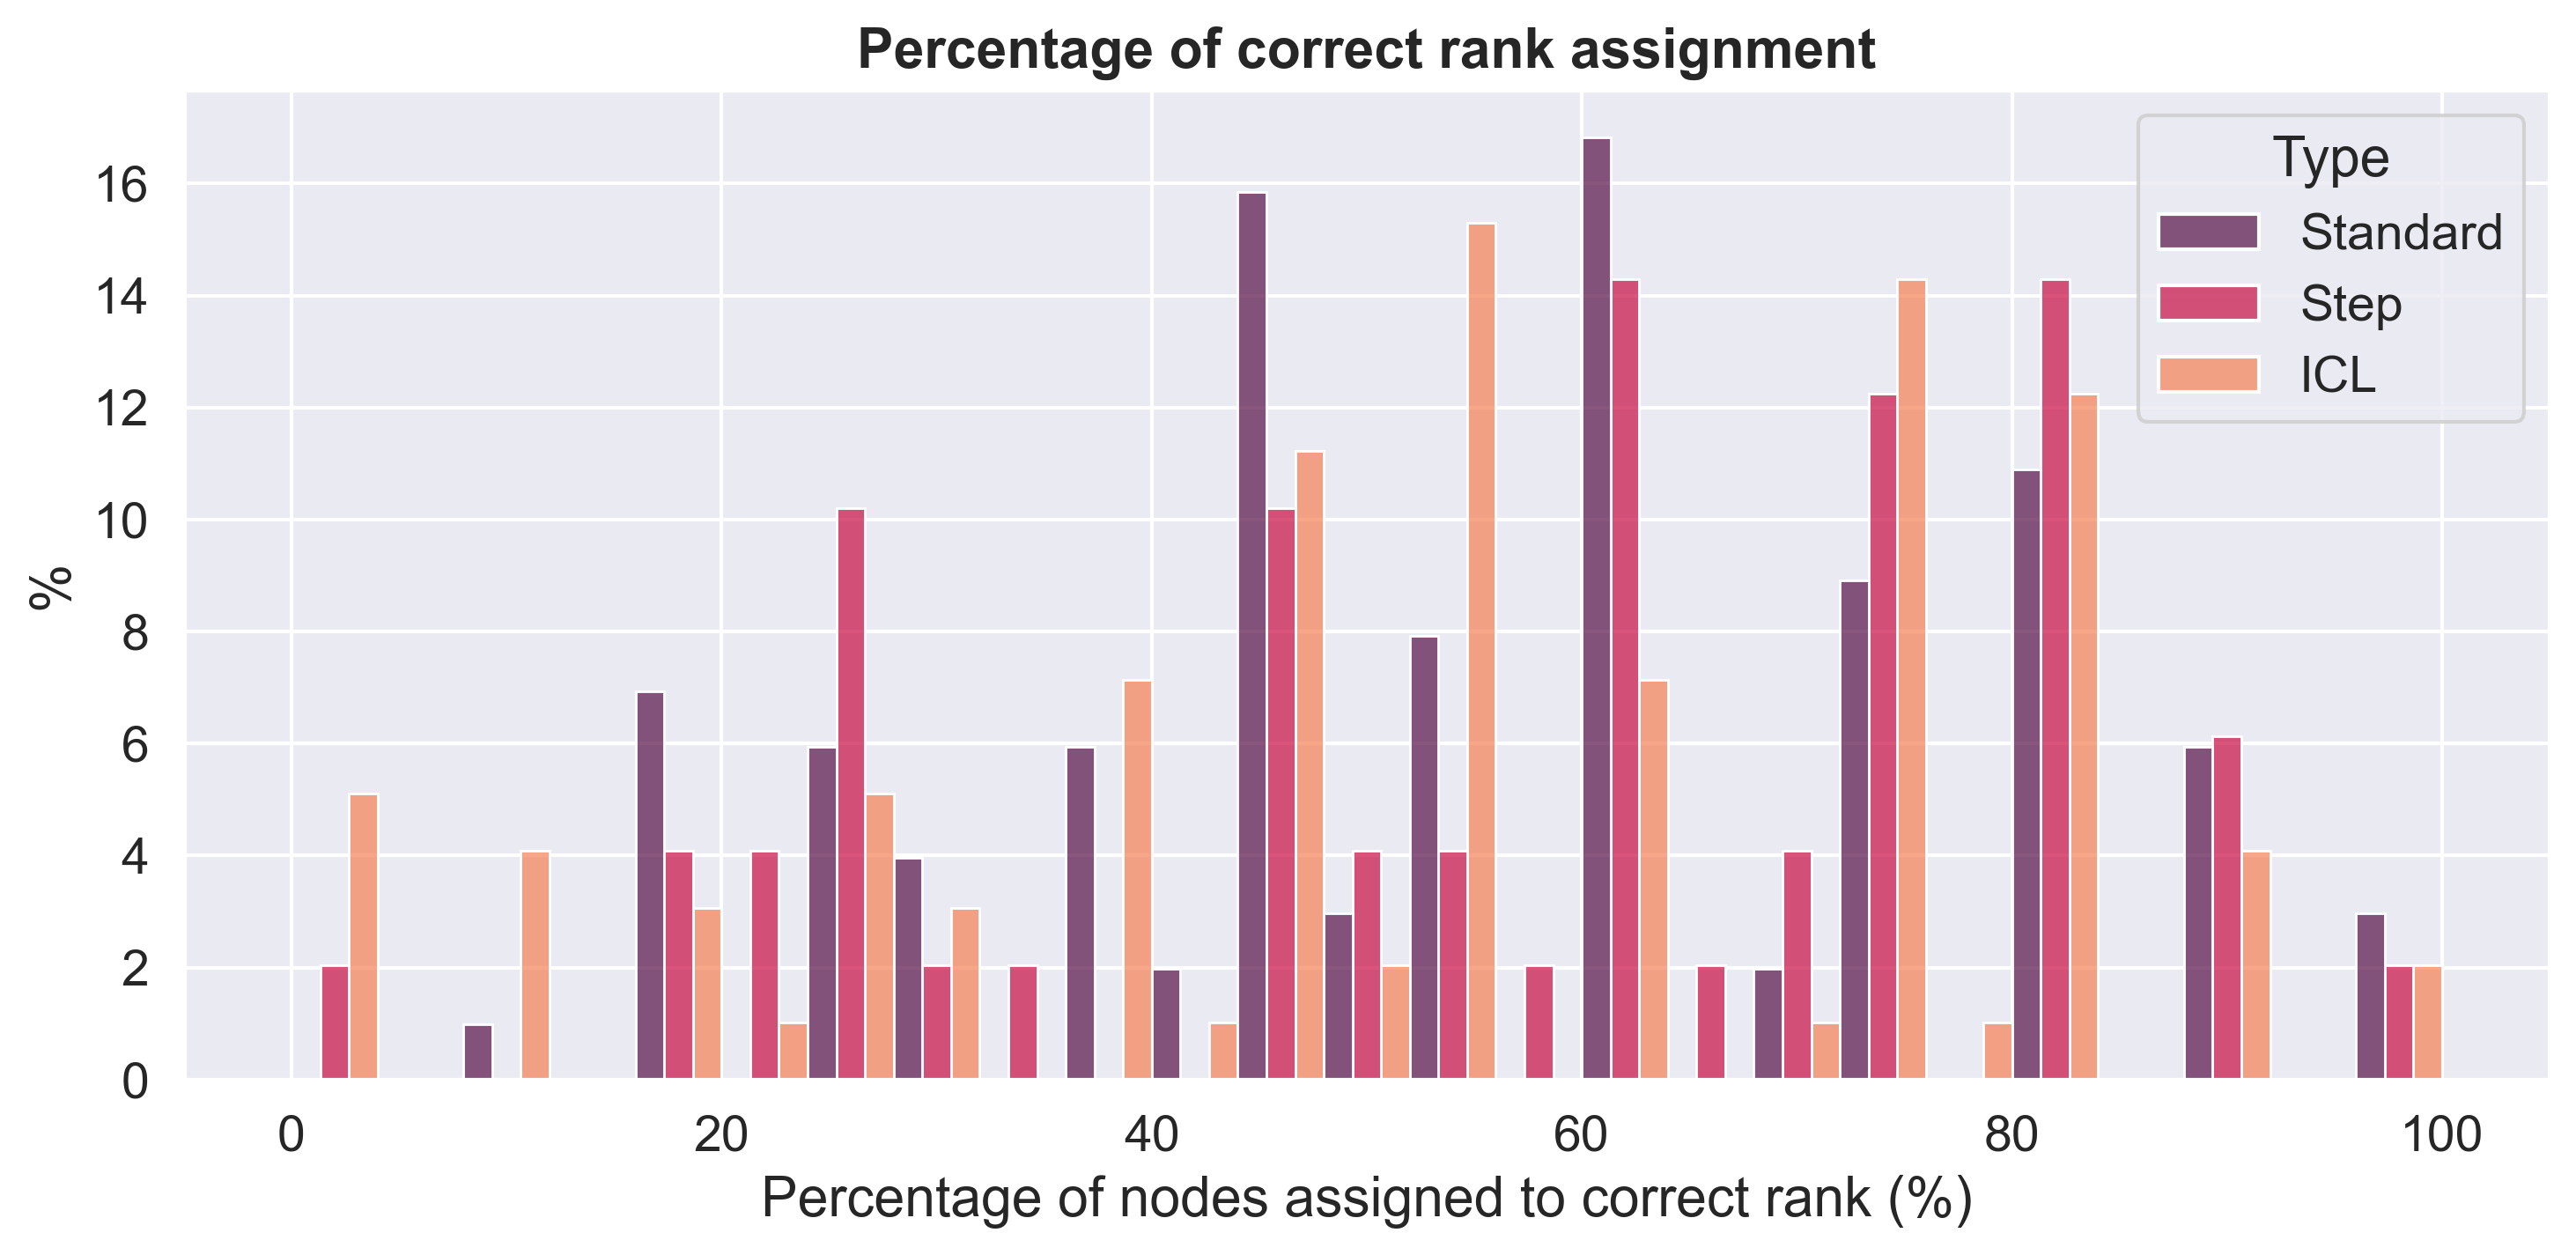

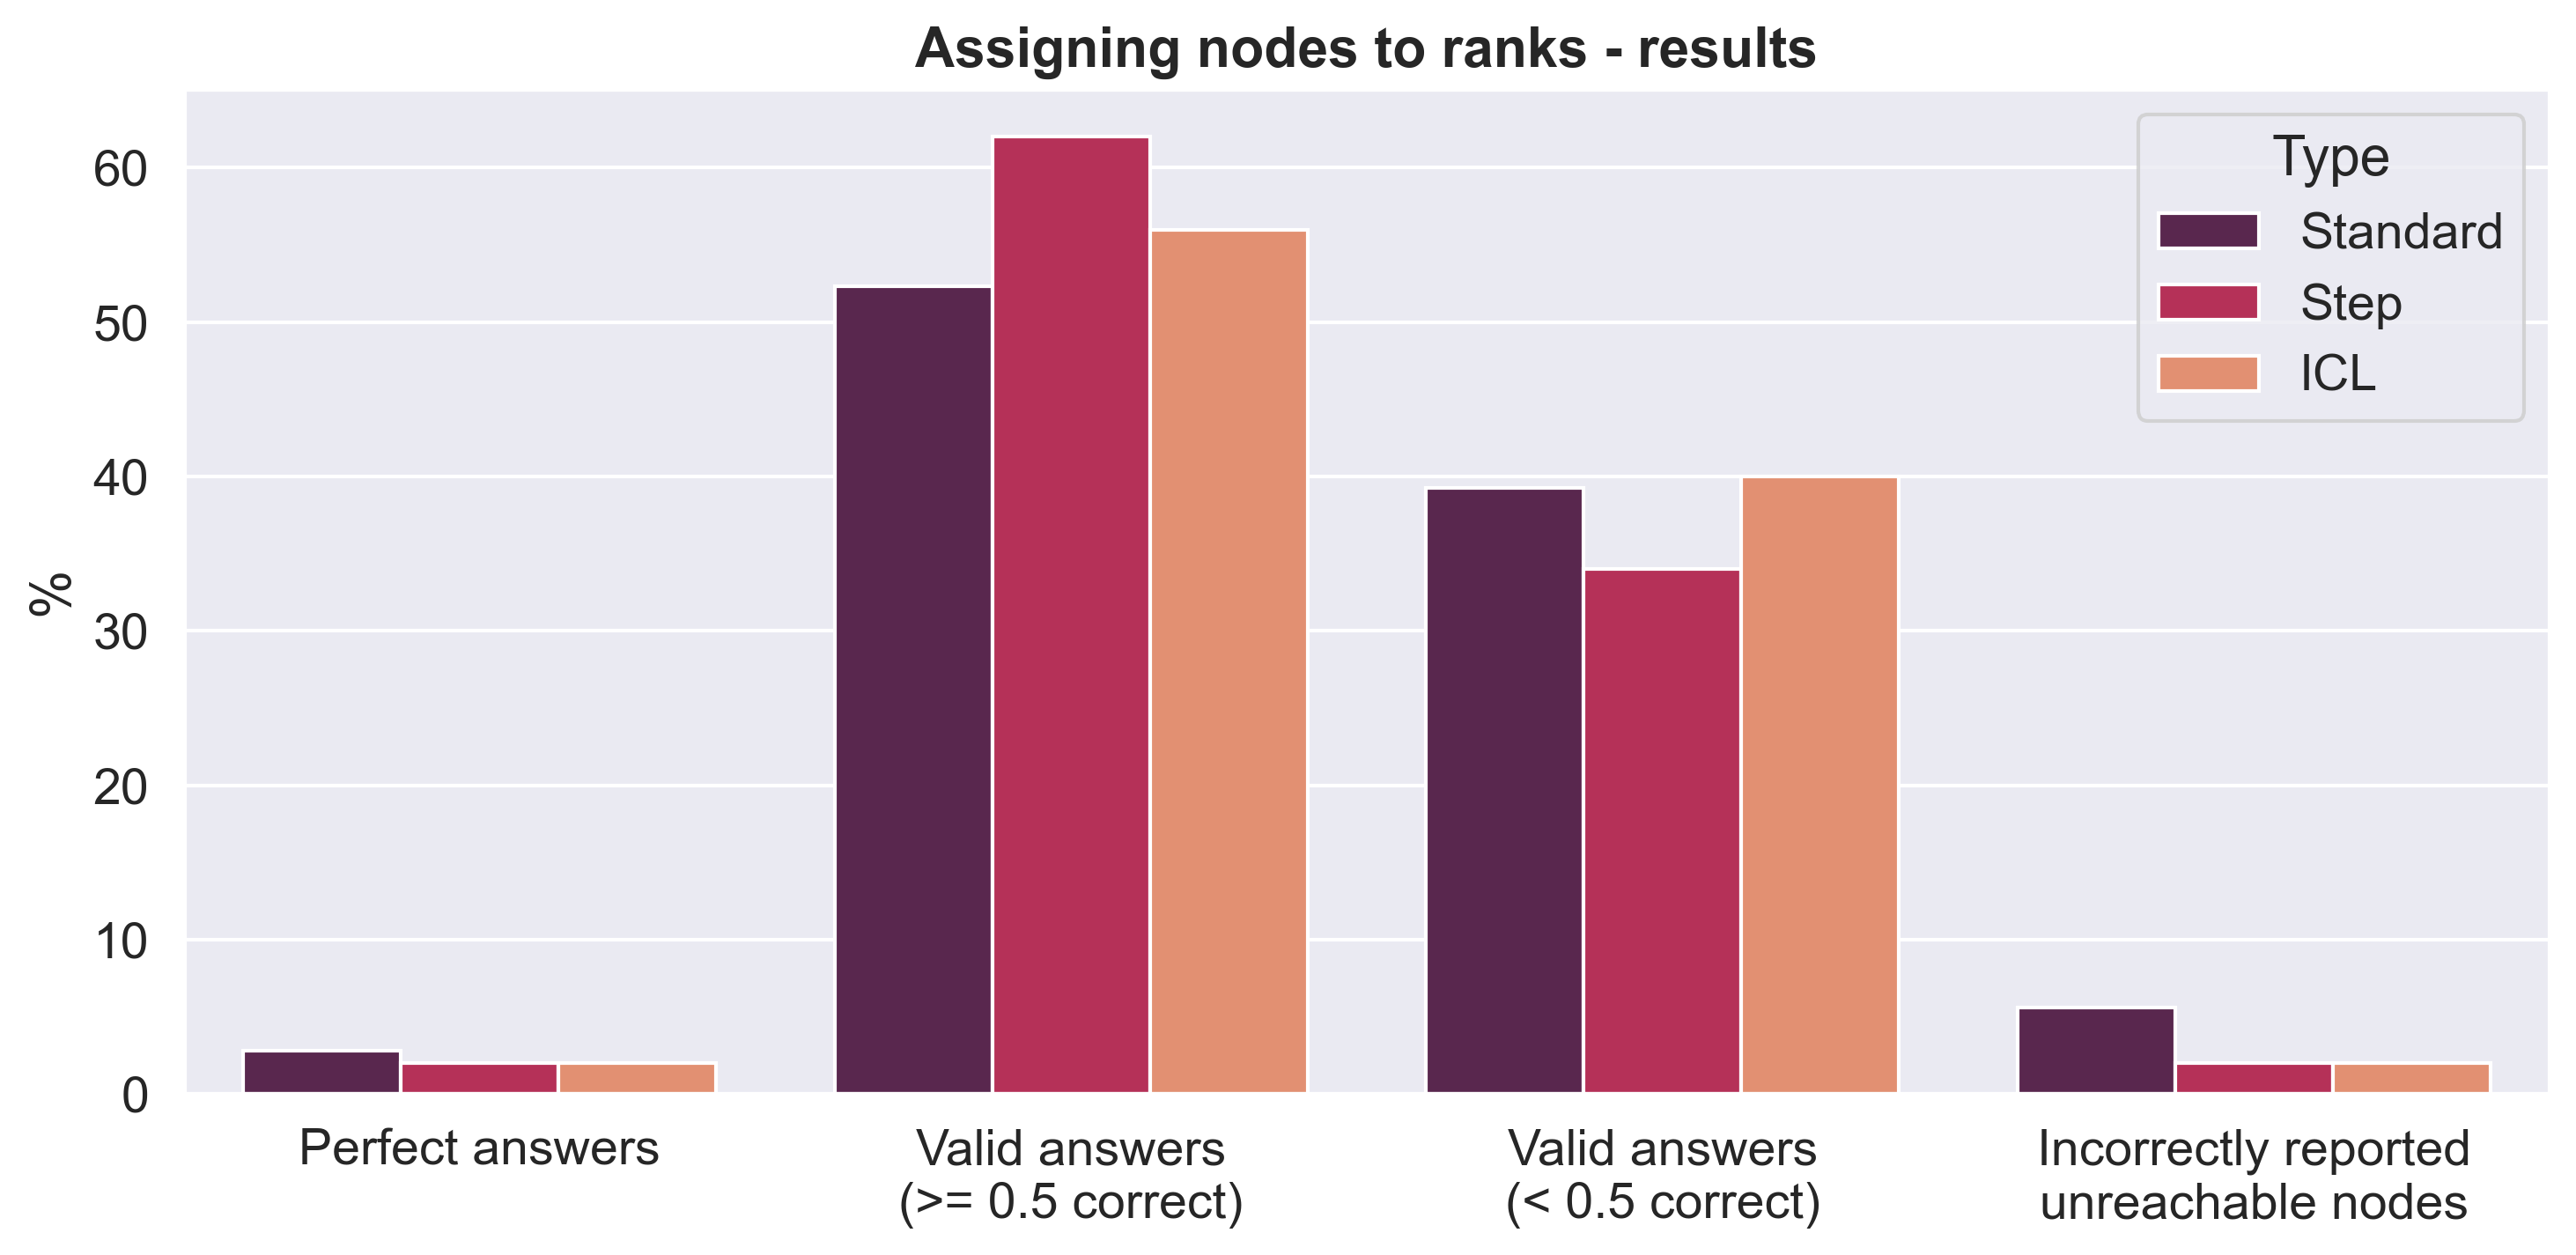

In [35]:
plt.figure(figsize=(10, 5), dpi = 300)
sns.set(font_scale=1.25)

# df is a dataframe with the following columns: "Type", "Correct". 
# Plot the histogram of the correct answers with different colors for different values of "Type"
sns.histplot(data=df, x="Correct [%]", hue="Type", bins=25, multiple="dodge", stat="percent", common_norm=False, palette="rocket")

plt.xlabel("Percentage of nodes assigned to correct rank (%)")
# plt.xlabel(None)
plt.title("Percentage of correct rank assignment", weight='bold')
plt.ylabel("%")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5), dpi = 300)
sns.set(font_scale=1.25)
sns.barplot(x=aggr.index, y="Value", data=aggr, hue="Type", palette="rocket")
plt.title("Assigning nodes to ranks - results", weight='bold')
plt.ylabel("%")
plt.tight_layout()
plt.show()